<a href="https://colab.research.google.com/github/prashanth-acsq/Colab-Notebooks/blob/main/scd/SCD_AE_Generate_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
import os
import re
import cv2
import torch
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from torchvision import models, transforms

from sklearn.model_selection import KFold

In [7]:
class CFG(object):
    def __init__(self, size: int = 224) -> None:
        self.size = size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.transform = transforms.Compose([transforms.ToTensor(), ])

cfg = CFG()


def predict(model=None, device=None, image=None, size=None, path=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    h, w, _ = image.shape
    temp_image = cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)

    with torch.no_grad(): _, decoded = model(transforms.ToTensor()(temp_image).unsqueeze(dim=0).to(cfg.device))
        
    decoded_image = np.clip(decoded.squeeze().detach().cpu().numpy().transpose(1, 2, 0)*255, 0, 255).astype("uint8")
    return cv2.resize(src=decoded_image, dsize=(w, h), interpolation=cv2.INTER_AREA)


def show(image: np.ndarray, cmap: str="gnuplot2") -> None:
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    plt.show()

In [4]:
class Model(nn.Module):
    def __init__(self, in_channels: int = 3):
        super(Model, self).__init__()

        self.encoder = models.resnet50(pretrained=False, progress=True)
        # self.freeze()
        self.encoder = nn.Sequential(*[*self.encoder.children()][:-2])
        if in_channels != 3:
            self.encoder[0] = nn.Conv2d(in_channels=in_channels, 
                                        out_channels=self.encoder[0].out_channels, 
                                        kernel_size=self.encoder[0].kernel_size, 
                                        stride=self.encoder[0].stride,
                                        padding=self.encoder[0].padding)
        self.decoder = nn.Sequential()
        self.decoder.add_module("DC1", nn.ConvTranspose2d(in_channels=2048, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN1", nn.ReLU())
        self.decoder.add_module("UP1", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC2", nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN2", nn.ReLU())
        self.decoder.add_module("UP2", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC3", nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN3", nn.ReLU())
        self.decoder.add_module("UP3", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC4", nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN4", nn.ReLU())
        self.decoder.add_module("UP4", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC5", nn.ConvTranspose2d(in_channels=64, out_channels=in_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN5", nn.ReLU())
        self.decoder.add_module("UP5", nn.Upsample(scale_factor=2))
    
    def freeze(self):
        for params in self.parameters(): params.requires_grad = False
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded
    

class Generator(nn.Module):
    def __init__(self, in_channels: int=3):
        super(Generator, self).__init__()

        self.decoder = nn.Sequential()
        self.decoder.add_module("DC1", nn.ConvTranspose2d(in_channels=2048, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN1", nn.ReLU())
        self.decoder.add_module("UP1", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC2", nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN2", nn.ReLU())
        self.decoder.add_module("UP2", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC3", nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN3", nn.ReLU())
        self.decoder.add_module("UP3", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC4", nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN4", nn.ReLU())
        self.decoder.add_module("UP4", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC5", nn.ConvTranspose2d(in_channels=64, out_channels=in_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN5", nn.ReLU())
        self.decoder.add_module("UP5", nn.Upsample(scale_factor=2))
    
    def forward(self, x):
        return self.decoder(x)

In [31]:
model = Model()

path = "/content/gdrive/My Drive/Models/scd/r50ae-na224.pt"
model.load_state_dict(torch.load(path, map_location=cfg.device)["model_state_dict"])
model.eval()

Model(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

In [21]:
generator_state_dict = dict()

for names, params in model.state_dict().items():
    if re.match(r"decoder", names, re.IGNORECASE):
        generator_state_dict[names] = params

generator = Generator()
generator.load_state_dict(generator_state_dict)
generator.eval()

Generator(
  (decoder): Sequential(
    (DC1): ConvTranspose2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (AN1): ReLU()
    (UP1): Upsample(scale_factor=2.0, mode=nearest)
    (DC2): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (AN2): ReLU()
    (UP2): Upsample(scale_factor=2.0, mode=nearest)
    (DC3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (AN3): ReLU()
    (UP3): Upsample(scale_factor=2.0, mode=nearest)
    (DC4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (AN4): ReLU()
    (UP4): Upsample(scale_factor=2.0, mode=nearest)
    (DC5): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (AN5): ReLU()
    (UP5): Upsample(scale_factor=2.0, mode=nearest)
  )
)

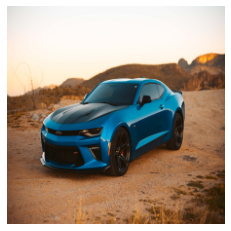

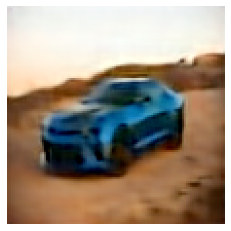

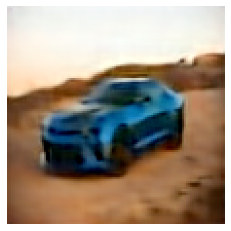

In [87]:
# temp = np.random.randint(low=0, high=255, size=(224, 224, 3), dtype=np.uint8)
temp = cv2.resize(src=cv2.cvtColor(src=cv2.imread('/content/Test.jpg', cv2.IMREAD_COLOR), code=cv2.COLOR_BGR2RGB), dsize=(cfg.size, cfg.size), interpolation=cv2.INTER_AREA)
de, op = model(transforms.ToTensor()(temp).to(cfg.device).unsqueeze(dim=0))
op_de = np.clip(generator(de).squeeze().detach().cpu().numpy().transpose(1, 2, 0)*255, 0, 255).astype("uint8")

show(temp)
show(np.clip(op.squeeze().detach().cpu().numpy().transpose(1, 2, 0)*255, 0, 255).astype("uint8"))
show(op_de)

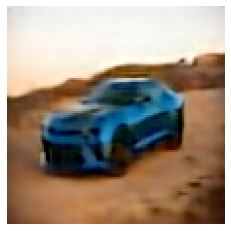

In [100]:
# ip = torch.rand(size=(1, 2048, 7, 7))
# ip = torch.normal(mean=5e-5, std=0.005, size=(1, 2048, 7, 7))
ip = de + torch.normal(mean=0.0005, std=0.0005, size=(1, 2048, 7, 7))

# op = generator(ip).squeeze().detach().cpu().numpy().transpose(1, 2, 0)
op = np.clip(generator(ip).squeeze().detach().cpu().numpy().transpose(1, 2, 0)*255, 0, 255).astype("uint8")

show(op)

In [90]:
de.mean()

tensor(0.0069, grad_fn=<MeanBackward0>)